# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep = ';')

### Display the data head

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print("Azdias Customers dataset has {} samples (rows) with {} features (column) each.".format(*azdias.shape))

Azdias Customers dataset has 891221 samples (rows) with 85 features (column) each.


In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


-----------------------------

In [5]:
print("Feature_summary dataset has {} samples (rows) with {} features (column) each.".format(*feat_info.shape))

Feature_summary dataset has 85 samples (rows) with 4 features (column) each.


In [6]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


### Exploring types and numbers of each variable

#### Azdias

In [7]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

#### Feature_info

In [8]:
feat_info.info

<bound method DataFrame.info of                 attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric

### Check types of missing or unknown variables

In [9]:
feat_info.groupby(by = "missing_or_unknown").size()

missing_or_unknown
[-1,0,9]     1
[-1,0]      16
[-1,9]      17
[-1,XX]      1
[-1,X]       1
[-1]        26
[0]         12
[XX]         1
[]          10
dtype: int64

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
# Identify missing or unknown data values and convert them to NaNs.

def get_individual_na_value(input_string): 
    # Convert '[-1,0]' to [-1,0] to make use of the replace method, 
    #Ref: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html
    split_word = input_string.replace('[','').replace(']','').split(',')
    return split_word


# Then, we replace:
for i in range(len(azdias.columns)): # loop through 85 columns of azdias
    azdias_col_name = azdias.columns[i] # Get azidias column name
    matched_NaN_value = feat_info.iloc[i,3] # From feature_info, get the matched NaN values of the azidias column name 
    NaN_list = get_individual_na_value(matched_NaN_value) # Get NaN list
    
    if NaN_list == ['']:
        continue
    else:
        for NaN_value in NaN_list: # NaN_value will take -1, 0, 9, XX
            if azdias[azdias_col_name].dtype == 'object': # datatype of azdias[azdias_col_name] has 3: int, float and object
                azdias.loc[azdias[azdias_col_name] == NaN_value, azdias_col_name] = np.nan
            else:
                NaN_value = int(NaN_value)
                azdias.loc[azdias[azdias_col_name] == NaN_value, azdias_col_name] = np.nan


            

In [11]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [12]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
# Get numbers of missing data in each column:
missing_data_column = azdias.isnull().sum() #Missing values gets mapped to True and non-missing value gets mapped to False. See https://www.geeksforgeeks.org/python-pandas-series-isnull/

missing_data_column

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

Text(0,0.5,'Frequency, \n relative to sum of all missing values')

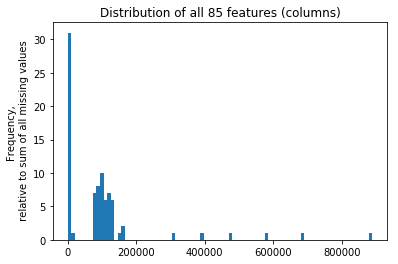

In [13]:
plt.hist(missing_data_column, bins = 85)
plt.title('Distribution of all 85 features (columns)')
plt.ylabel('Frequency, \n relative to sum of all missing values')

We can see that the data is skewed seriously, lets see the statistics of the data

In [14]:
# Investigate patterns in the amount of missing data in each column.
missing_data_column.describe()

count        85.000000
mean      98516.811765
std      146604.203317
min           0.000000
25%           0.000000
50%       93148.000000
75%      116515.000000
max      889061.000000
dtype: float64

Using a boxplot, lets find the outliers of the data

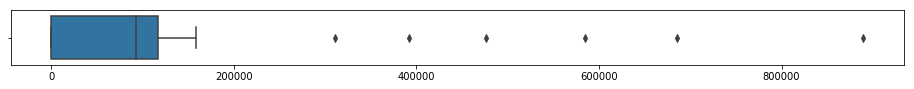

In [15]:
# Set figure size:
plt.figure(figsize = (16, 1))
# Draw the figure:
sns.boxplot(x = missing_data_column)

Find the upper limit that defines outliers, which is Q3 + (1.5 * IQR)

In [16]:
Q1,Q3 = np.percentile(missing_data_column, [25,75])
IQR = Q3 - Q1
outlier_limit = 1.5 * IQR + Q3
print ("outlier_limit is: ", outlier_limit)

outlier_limit is:  291287.5


Find the total number of outliers, the smallest and largest outliers：

In [17]:
from operator import itemgetter

outliers_list = []
outliers_column_name = []
outliers_count = 0
for i in range(len(azdias.columns)):
    if azdias.iloc[:,i].isnull().sum() > outlier_limit:
        outliers_list.append([azdias.columns[i], azdias.iloc[:,i].isnull().sum()])
        outliers_column_name.append(azdias.columns[i])
        outliers_list = sorted(outliers_list, key = itemgetter(1))
        outliers_count += 1   
    
print (outliers_list)
print ("------------------------------------")
print ("We have", outliers_count, "outliers.",\
       "The largest outlier is: ", outliers_list[-1]\
       ,", the smallest outlier is: ", outliers_list[0])

[['ALTER_HH', 310267], ['GEBURTSJAHR', 392318], ['KBA05_BAUMAX', 476524], ['KK_KUNDENTYP', 584612], ['AGER_TYP', 685843], ['TITEL_KZ', 889061]]
------------------------------------
We have 6 outliers. The largest outlier is:  ['TITEL_KZ', 889061] , the smallest outlier is:  ['ALTER_HH', 310267]


In [18]:
azdias.shape

(891221, 85)

In [19]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
droped_azdias = azdias
droped_azdias.drop(outliers_column_name, axis = 1, inplace = True)
droped_azdias.shape


(891221, 79)

Text(0,0.5,'Frequency, \n relative to sum of all missing values')

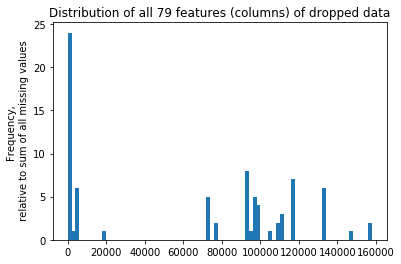

In [20]:
plt.hist(azdias.isnull().sum(), bins = 79)
plt.title('Distribution of all 79 features (columns) of dropped data')
plt.ylabel('Frequency, \n relative to sum of all missing values')

Let's then check how many columns are without missing values in the new, dropped dataset.

In [21]:
count = 0
column_names_no_missing_value = []
for i in range(azdias.shape[1]):
    if azdias.iloc[:,i].isnull().sum() == 0: # 0 NaNs
        count += 1
        column_names_no_missing_value.append(azdias.columns[i])
print ("we have", count, "columns without missing values \n",\
       "Column names are: \n",column_names_no_missing_value)

we have 24 columns without missing values 
 Column names are: 
 ['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ZABEOTYP']


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

#### Answer

Using the Q3 + (1.5 * IQR) metrics, we identified that 6 columns has outliers greater than that limit, i.e., 291287. Column names and numbers of missing values of these outliers are [['ALTER_HH', 310267], ['GEBURTSJAHR', 392318], ['KBA05_BAUMAX', 476524], ['KK_KUNDENTYP', 584612], ['AGER_TYP', 685843], ['TITEL_KZ', 889061]]. Column with the largest outlier is:  ['TITEL_KZ', 889061] , the smallest outlier is:  ['ALTER_HH', 310267]. Since most of the columns have number of outliers that is below 291287, I decided to remove these 6 columns.

lets then check patterns of missing data in each column:

In [22]:
summary_of_missing_data = {}
for i in range(azdias.shape[1]):
    if azdias.iloc[:,i].isnull().sum() > 0: # select columns with outliers
        summary_of_missing_data[azdias.columns[i]] = azdias.iloc[:,i].isnull().sum()
summary_of_missing_data

{'ALTERSKATEGORIE_GROB': 2881,
 'CJT_GESAMTTYP': 4854,
 'GFK_URLAUBERTYP': 4854,
 'HEALTH_TYP': 111196,
 'LP_LEBENSPHASE_FEIN': 97632,
 'LP_LEBENSPHASE_GROB': 94572,
 'LP_FAMILIE_FEIN': 77792,
 'LP_FAMILIE_GROB': 77792,
 'LP_STATUS_FEIN': 4854,
 'LP_STATUS_GROB': 4854,
 'NATIONALITAET_KZ': 108315,
 'PRAEGENDE_JUGENDJAHRE': 108164,
 'RETOURTYP_BK_S': 4854,
 'SHOPPER_TYP': 111196,
 'SOHO_KZ': 73499,
 'VERS_TYP': 111196,
 'ANZ_PERSONEN': 73499,
 'ANZ_TITEL': 73499,
 'HH_EINKOMMEN_SCORE': 18348,
 'W_KEIT_KIND_HH': 147988,
 'WOHNDAUER_2008': 73499,
 'ANZ_HAUSHALTE_AKTIV': 99611,
 'ANZ_HH_TITEL': 97008,
 'GEBAEUDETYP': 93148,
 'KONSUMNAEHE': 73969,
 'MIN_GEBAEUDEJAHR': 93148,
 'OST_WEST_KZ': 93148,
 'WOHNLAGE': 93148,
 'CAMEO_DEUG_2015': 99352,
 'CAMEO_DEU_2015': 99352,
 'CAMEO_INTL_2015': 99352,
 'KBA05_ANTG1': 133324,
 'KBA05_ANTG2': 133324,
 'KBA05_ANTG3': 133324,
 'KBA05_ANTG4': 133324,
 'KBA05_GBZ': 133324,
 'BALLRAUM': 93740,
 'EWDICHTE': 93740,
 'INNENSTADT': 93740,
 'GEBAEUDETYP_RAST

We noticed that many columns have same numbers of outliers, now we pick them out:

In [23]:
unique_values = set(summary_of_missing_data.values())
#unique_values
same_outlier_column = []
for i in unique_values:
    for k,v in summary_of_missing_data.items():
        if v == i:
            same_outlier_column = [k for k,v in summary_of_missing_data.items() if v == i]
    print (same_outlier_column, i)

['PRAEGENDE_JUGENDJAHRE'] 108164
['W_KEIT_KIND_HH'] 147988
['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015'] 99352
['SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL', 'WOHNDAUER_2008'] 73499
['ANZ_HAUSHALTE_AKTIV'] 99611
['NATIONALITAET_KZ'] 108315
['PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ'] 116515
['HH_EINKOMMEN_SCORE'] 18348
['BALLRAUM', 'EWDICHTE', 'INNENSTADT'] 93740
['ALTERSKATEGORIE_GROB'] 2881
['KBA13_ANZAHL_PKW'] 105800
['KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'MOBI_REGIO'] 133324
['GEBAEUDETYP', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE'] 93148
['HEALTH_TYP', 'SHOPPER_TYP', 'VERS_TYP'] 111196
['ARBEIT', 'RELAT_AB'] 97375
['LP_LEBENSPHASE_FEIN'] 97632
['LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB'] 77792
['GEBAEUDETYP_RASTER'] 93155
['LP_LEBENSPHASE_GROB'] 94572
['ANZ_HH_TITEL'] 97008
['KONSUMNAEHE'] 73969
['KKK', 'REGIOTYP'] 158064
['CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',

We can see that 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ' all have 116515 outliers. Let's check what are those columns stand for.

In [24]:
feat_info.set_index("attribute", inplace=True)
feat_info.loc[['PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ']]

,information_level,type,missing_or_unknown
attribute,,,
PLZ8_ANTG1,macrocell_plz8,ordinal,[-1]
PLZ8_ANTG2,macrocell_plz8,ordinal,[-1]
PLZ8_ANTG3,macrocell_plz8,ordinal,[-1]
PLZ8_ANTG4,macrocell_plz8,ordinal,[-1]
PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"
PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
PLZ8_GBZ,macrocell_plz8,ordinal,[-1]


It seems that they are all at the "macrocell_plz8" information_level, which represent the number of 1-2 family houses in the PLZ8 region, since they are somewhat similar, we could possibly keep one of them for simplicity

Besides, we also have 4854 outliers for columns ['CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'RETOURTYP_BK_S', 'ONLINE_AFFINITAET'], so lets see what are those：

In [25]:
feat_info.loc[['CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'RETOURTYP_BK_S', 'ONLINE_AFFINITAET']]

,information_level,type,missing_or_unknown
attribute,,,
CJT_GESAMTTYP,person,categorical,[0]
GFK_URLAUBERTYP,person,categorical,[]
LP_STATUS_FEIN,person,categorical,[0]
LP_STATUS_GROB,person,categorical,[0]
RETOURTYP_BK_S,person,ordinal,[0]
ONLINE_AFFINITAET,region_rr1,ordinal,[]


Our results show that they cover the "person" information_level. These data may relate to a same person.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [26]:
# How much data is missing in each row of the dataset?
# https://datascience.stackexchange.com/questions/12645/how-to-count-the-number-of-missing-values-in-each-row-in-pandas-dataframe
missing_data_row = azdias.isnull().sum(axis = 1)#Missing values gets mapped to True and non-missing value gets mapped to False. See https://www.geeksforgeeks.org/python-pandas-series-isnull/
print ("missing data in each row: \n", missing_data_row,"\n")

missing data in each row: 
 0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64 



Text(0,0.5,'Frequency, \n relative to sum of all missing values')

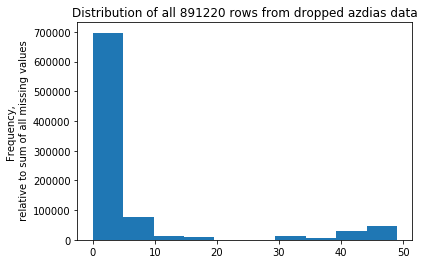

In [27]:
plt.hist(missing_data_row)
plt.title('Distribution of all 891220 rows from dropped azdias data')
plt.ylabel('Frequency, \n relative to sum of all missing values')

In [28]:
missing_data_row.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

In [29]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

#https://stackoverflow.com/questions/36733639/how-to-filter-rows-that-fall-within-1st-and-3rd-quartile-of-a-particular-column
def subsets(dataframe, cutoff_value):
    '''
    Input: dataframe, cutoff_value
    Output: two sub-datasets from dataframe, cut off by the cutoff_value
    '''
    threshold = dataframe.isnull().sum(axis = 1).quantile([cutoff_value]).tolist()
    
    less_nan_rows = dataframe[dataframe.isnull().sum(axis = 1) <= threshold]
    more_nan_rows = dataframe[dataframe.isnull().sum(axis = 1) > threshold]
    
    return less_nan_rows, more_nan_rows

In [30]:
less_nan_rows, more_nan_rows = subsets(azdias, 0.75)
print ("Shape of less Nan rows: ", less_nan_rows.shape)
print ("Shape of more Nan rows: ", more_nan_rows.shape)

Shape of less Nan rows:  (684502, 79)
Shape of more Nan rows:  (206719, 79)


In [31]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# 1. Find out columns with no missing values:
# This step is essentially the same with previous methods seen before
def get_columns_without_missing_values(dataframe):
    '''
    Input: Dataframe
    Output: List of column names with no missing values
    '''
    output = []
    for i in range(dataframe.shape[1]):
        if dataframe.iloc[:,i].isnull().sum() == 0:
            output.append(dataframe.columns[i])
    return output

In [32]:
# 2. For rows with less and more nans (less_nan_rows and more_nan_rows),
#find subsets with columns that contain no missing values (intersect with column names of no missing values):
# These column names may be different from previous codes, since the object here are two subsets, instead of 
#the whole dataframe

column_names_without_missing_value_of_less_nan_rows = get_columns_without_missing_values(less_nan_rows)
column_names_without_missing_value_of_more_nan_rows = get_columns_without_missing_values(more_nan_rows)


In [33]:
print ("less: ", column_names_without_missing_value_of_less_nan_rows)
print ("\n")
print ("more: ", column_names_without_missing_value_of_more_nan_rows)

less:  ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'WOHNDAUER_2008', 'GEBAEUDETYP', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ']


more:  ['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', '

    100% |████████████████████████████████| 40kB 3.6MB/s ta 0:00:01
  Running setup.py bdist_wheel for matplotlib-venn ... done
  Stored in directory: /root/.cache/pip/wheels/d8/88/2f/e41518cb16e58109e8d14dc5dd7ef8166c82dce86c7c6d6c80
Successfully built matplotlib-venn


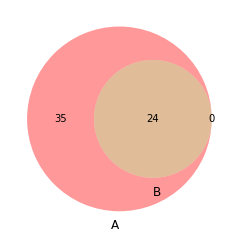

In [35]:
# We use venn graph to show the relationship between the column names of these two sets:
%matplotlib inline

!pip install matplotlib-venn
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt

venn2([set(column_names_without_missing_value_of_less_nan_rows), set(column_names_without_missing_value_of_more_nan_rows)])

In [36]:
# 3. Select column names that are shared between two lists:

#https://www.geeksforgeeks.org/python-intersection-two-lists/
# Python program to illustrate the intersection 
# of two lists using set() method 
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

shared_col_names = intersection(column_names_without_missing_value_of_less_nan_rows, \
                                column_names_without_missing_value_of_more_nan_rows)
shared_col_names

['FINANZ_SPARER',
 'FINANZ_HAUSBAUER',
 'SEMIO_DOM',
 'FINANZ_ANLEGER',
 'SEMIO_ERL',
 'FINANZ_VORSORGER',
 'SEMIO_TRADV',
 'SEMIO_SOZ',
 'GREEN_AVANTGARDE',
 'SEMIO_KAEM',
 'FINANZ_MINIMALIST',
 'SEMIO_PFLICHT',
 'ANREDE_KZ',
 'SEMIO_LUST',
 'FINANZTYP',
 'SEMIO_REL',
 'FINANZ_UNAUFFAELLIGER',
 'SEMIO_FAM',
 'SEMIO_RAT',
 'ZABEOTYP',
 'SEMIO_KULT',
 'SEMIO_VERT',
 'SEMIO_KRIT',
 'SEMIO_MAT']

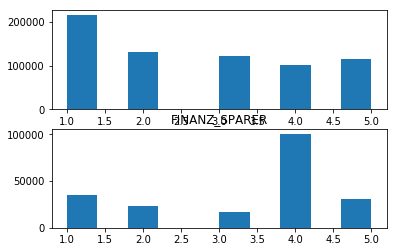

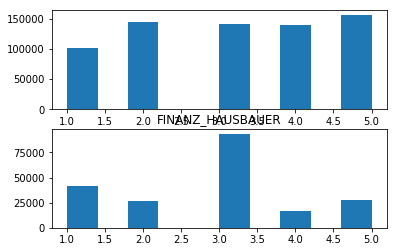

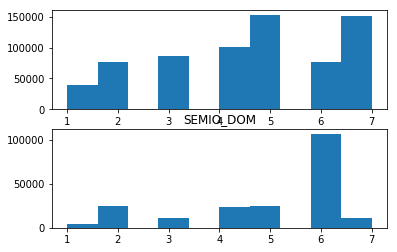

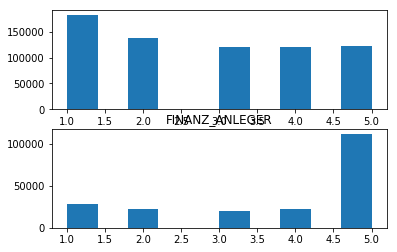

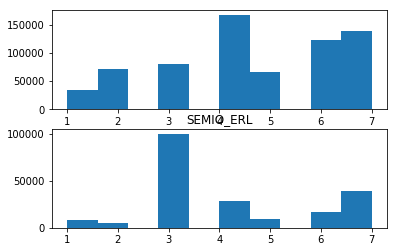

In [37]:
# Now we plot 5 of the columns out:
for i in range(len(shared_col_names[:5])):
    col_name_for_comparison = shared_col_names[i]
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(211)
    ax1.hist(less_nan_rows[col_name_for_comparison])
    ax2 = fig1.add_subplot(212)
    ax2.hist(more_nan_rows[col_name_for_comparison])
    plt.title(col_name_for_comparison)
    #plt.show()


Text(0.5,1,'SEMIO_ERL')

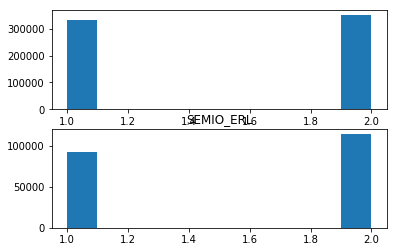

In [38]:
# Through plotting all distribution, we found this one with similar distribution between two subsets:
fig1 = plt.figure()
ax1 = fig1.add_subplot(211)
ax1.hist(less_nan_rows['ANREDE_KZ'])
ax2 = fig1.add_subplot(212)
ax2.hist(more_nan_rows['ANREDE_KZ'])
plt.title(col_name_for_comparison)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

We can see from the azdias.isnull().sum(axis = 1) that the mean of all NaN numbers is 5.64, the max is 49, and the 3/4 quantile is only 3. This pattern suggests that the distribution is severly skewed, specifically, the large counts have pulled up the mean value.

For outlier data separating, I choose the 3rd quantile as a cutoff value. Thus, rows with less than 3 NaNs are separated from the rest, leaving the other arm holding rows with more than 4 NaNs.

When we compare the distribution between less and higher NaNs, we found several distinctions. For columns ['SEMIO_RAT',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'SEMIO_MAT',
 'SEMIO_PFLICHT'], the data distribution is different. For columns [ANREDE_KZ], however, the distribution is similar. In conclusion, clear differences exist between two groups.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

For further analysis, we choose subset with less or no missing values, thus we now focus on the less_nan subset:

In [39]:
less_nan_rows.shape #should return (684502, 79)

(684502, 79)

In [40]:
less_nan_rows.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,4.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0


In [41]:
# Load in the feature summary file again.
# Find the data type of each column
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep = ';')

In [42]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [43]:
# How many numbers are there of each data type?
feat_info.groupby(by="type").size()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

First, we select all categorical variables:

In [44]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

In [45]:
cat_variables = []
for i in range(feat_info.shape[0]):
    if feat_info['type'][i] == 'categorical':
        cat_variables.append(feat_info['attribute'][i])

In [46]:
print (cat_variables)

['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [47]:
less_nan_shared_col = intersection(column_names_without_missing_value_of_less_nan_rows, cat_variables)
print (less_nan_shared_col)

['LP_STATUS_FEIN', 'GEBAEUDETYP', 'CJT_GESAMTTYP', 'ZABEOTYP', 'GREEN_AVANTGARDE', 'FINANZTYP', 'OST_WEST_KZ', 'LP_STATUS_GROB', 'LP_FAMILIE_GROB', 'SOHO_KZ', 'SHOPPER_TYP', 'LP_FAMILIE_FEIN', 'GFK_URLAUBERTYP', 'VERS_TYP', 'NATIONALITAET_KZ', 'ANREDE_KZ']


Then, we find the binary and multi- categorical data:

1. Binary categorical variables:

In [48]:
Binary_col_names = []
for i in less_nan_shared_col:
    if len(set(less_nan_rows[i].values)) == 2: # using a "set", we dereplicate integers and return unique values
        Binary_col_names.append(i)
print ("Binary categorical variables:", Binary_col_names)

Binary categorical variables: ['GREEN_AVANTGARDE', 'OST_WEST_KZ', 'SOHO_KZ', 'VERS_TYP', 'ANREDE_KZ']


Let's check those variables:

In [49]:
less_nan_rows[Binary_col_names].head()

,GREEN_AVANTGARDE,OST_WEST_KZ,SOHO_KZ,VERS_TYP,ANREDE_KZ
1,0,W,1.0,2.0,2.0
2,1,W,0.0,1.0,2.0
4,0,W,0.0,2.0,1.0
5,0,W,0.0,2.0,2.0
6,0,W,0.0,1.0,2.0


! Attention ! We found that OST_WEST_KZ is not numerical, we may recode it later

2. Multi-level categorical variables:

In [50]:
Multi_col_names = []
for i in less_nan_shared_col:
    if len(set(less_nan_rows[i].values)) > 2: # using a "set", we dereplicate integers and return unique values
        Multi_col_names.append(i)
print ("Multi-level categorical variables:", Multi_col_names,\
      "\nNum of these cols:", len(Multi_col_names))

Multi-level categorical variables: ['LP_STATUS_FEIN', 'GEBAEUDETYP', 'CJT_GESAMTTYP', 'ZABEOTYP', 'FINANZTYP', 'LP_STATUS_GROB', 'LP_FAMILIE_GROB', 'SHOPPER_TYP', 'LP_FAMILIE_FEIN', 'GFK_URLAUBERTYP', 'NATIONALITAET_KZ'] 
Num of these cols: 11


In [51]:
less_nan_rows[Multi_col_names].head()

,LP_STATUS_FEIN,GEBAEUDETYP,CJT_GESAMTTYP,ZABEOTYP,FINANZTYP,LP_STATUS_GROB,LP_FAMILIE_GROB,SHOPPER_TYP,LP_FAMILIE_FEIN,GFK_URLAUBERTYP,NATIONALITAET_KZ
1,2.0,8.0,5.0,5.0,1.0,1.0,3.0,3.0,5.0,10.0,1.0
2,3.0,1.0,3.0,5.0,1.0,2.0,1.0,2.0,1.0,10.0,1.0
4,3.0,1.0,5.0,4.0,5.0,2.0,5.0,2.0,10.0,5.0,1.0
5,4.0,1.0,2.0,4.0,2.0,2.0,1.0,0.0,1.0,1.0,1.0
6,2.0,1.0,5.0,4.0,4.0,1.0,1.0,1.0,1.0,12.0,1.0


4. Re-encode categorical variables, first we re-encode the OST_WEST_KZ:

In [52]:
# See what's inside of OST_WEST_KZ:
set(less_nan_rows['OST_WEST_KZ'].values)

{'O', 'W'}

In [53]:
# re-encode the column:
# 1. add new column to temporarily hold OST_WEST_KZ:
less_nan_rows['encode_OST_WEST_KZ'] = less_nan_rows['OST_WEST_KZ']
# 2. replace:
less_nan_rows['encode_OST_WEST_KZ'] = less_nan_rows['encode_OST_WEST_KZ'].replace({'W': 0, 'O': 1})
# 3. drop old column:
less_nan_rows = less_nan_rows.copy()
less_nan_rows.drop(['OST_WEST_KZ'], axis=1, inplace=True)
less_nan_rows.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


(684502, 79)

Now let's check if it's indeed replace with 0 and 1

In [54]:
less_nan_rows.loc[:,['encode_OST_WEST_KZ']].head()

,encode_OST_WEST_KZ
1,0
2,0
4,0
5,0
6,0


Now the W and O values have been changed into 0 and 1. Now it's time for one-hot encoding !

In [55]:
# First check the shape of less_nan dataframe
less_nan_rows.shape

(684502, 79)

In [56]:
# Get all categorical dataframe and convert them all to strings:
multi_cat_less_nan_rows = less_nan_rows[Multi_col_names].astype(str)
#multi_category = pd.DataFrame(less_nan[Multi], columns = Multi).astype(str)

In [57]:
multi_cat_less_nan_rows.shape # (684502, 11)

(684502, 11)

In [58]:
multi_cat_less_nan_rows.head()

,LP_STATUS_FEIN,GEBAEUDETYP,CJT_GESAMTTYP,ZABEOTYP,FINANZTYP,LP_STATUS_GROB,LP_FAMILIE_GROB,SHOPPER_TYP,LP_FAMILIE_FEIN,GFK_URLAUBERTYP,NATIONALITAET_KZ
1,2.0,8.0,5.0,5.0,1.0,1.0,3.0,3.0,5.0,10.0,1.0
2,3.0,1.0,3.0,5.0,1.0,2.0,1.0,2.0,1.0,10.0,1.0
4,3.0,1.0,5.0,4.0,5.0,2.0,5.0,2.0,10.0,5.0,1.0
5,4.0,1.0,2.0,4.0,2.0,2.0,1.0,0.0,1.0,1.0,1.0
6,2.0,1.0,5.0,4.0,4.0,1.0,1.0,1.0,1.0,12.0,1.0


In [59]:
# Re-encode categorical variable(s) to be kept in the analysis.
# One-hot encoding
one_hot_encoded_multi_cat_less_nan_rows = pd.get_dummies(multi_cat_less_nan_rows)

In [60]:
one_hot_encoded_multi_cat_less_nan_rows.shape #(684502, 75)

(684502, 75)

In [61]:
one_hot_encoded_multi_cat_less_nan_rows.head()

,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_10.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,...,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [62]:
# Drop original 
less_nan_rows.drop(Multi_col_names, axis=1, inplace=True)
less_nan_rows.shape # 79-11=68

(684502, 68)

In [63]:
# Combine one-hot with the original (after dropped)
less_nan_encoded_combined = pd.concat([less_nan_rows, one_hot_encoded_multi_cat_less_nan_rows], axis=1)
less_nan_encoded_combined.shape # 68+75=143

(684502, 143)

In [64]:
less_nan_encoded_combined.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,0,0,0,0,0,0,0,1,0,0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,0,0,0,0,0,0,0,1,0,0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,0,0,1,0,0,0,0,1,0,0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,0,0,0,0,0,0,0,1,0,0
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0,2.0,...,0,0,0,0,0,0,0,1,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

- First, I separate the category into binary and multi-category.
- Next, I noticed that one column, the "OST_WEST_KZ", contains non-numerical data as "W" and "O", thus I manually re-encode them into 0 and 1.
- Next, I leave the binary coding alone, but focus on multi-category data, and I use one-hot encoding to re-encode that data. 
- Last, I combine the original dataframe with the one-hot encoded data to create a new dataframe.
- After one-hot encoding, I have a dataframe with 684502 rows and 143 columns

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [65]:
# Let's first see what's in PRAEGENDE_JUGENDJAHRE:
less_nan_encoded_combined['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    159363
8.0     125180
5.0      76109
10.0     74700
3.0      47716
15.0     36392
11.0     30813
9.0      30760
6.0      23796
12.0     22146
4.0      19014
1.0      16625
2.0       6468
13.0      4916
7.0       3708
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [66]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# We make use of the "map" function: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html

# For the dimension of "decade":
replace_dict1 = {1: 1, 2: 1, 3: 2, 4: 2, 5: 3,\
               6: 3, 7: 4, 8: 4, 9: 5, 10: 5,\
               11: 6, 12: 6, 13: 7, 14: 7, 15: 8}

less_nan_encoded_combined['new_PRA_JUG_dec'] = less_nan_encoded_combined['PRAEGENDE_JUGENDJAHRE']
less_nan_encoded_combined['new_PRA_JUG_dec'] = less_nan_encoded_combined['new_PRA_JUG_dec'].map(replace_dict1)

# For the dimension of "movement":
replace_dict2 = {1: 0, 2: 1, 3: 0, 4: 1, 5: 0,\
               6: 1, 7: 0, 8: 1, 9: 0, 10: 1,\
               11: 0, 12: 1, 13: 0, 14: 1, 15: 0}

less_nan_encoded_combined['new_PRA_JUG_mov'] = less_nan_encoded_combined['PRAEGENDE_JUGENDJAHRE']
less_nan_encoded_combined['new_PRA_JUG_mov'] = less_nan_encoded_combined['new_PRA_JUG_mov'].map(replace_dict2)

# Drop the original column:
less_nan_encoded_combined.drop(["PRAEGENDE_JUGENDJAHRE"], axis=1, inplace=True) 
less_nan_encoded_combined.shape

(684502, 144)

Now let's explore "CAMEO_INTL_2015"

In [67]:
# Let's first see what's in CAMEO_INTL_2015:
less_nan_encoded_combined['CAMEO_INTL_2015'].value_counts()

51    116352
41     80374
24     78772
14     54607
43     49530
54     40054
25     34901
22     27974
45     23281
13     22702
55     20623
23     18578
52     17714
34     16004
15     15247
31     14767
44     12878
12     11164
35      9037
32      8974
33      8330
Name: CAMEO_INTL_2015, dtype: int64

In [68]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# For the dimension of "wealth":

replace_dict1 = {'11': 1.0, '12': 1.0, '13': 1.0, '14': 1.0, '15': 1.0,\
                      '21': 2.0, '22': 2.0, '23': 2.0, '24': 2.0, '25': 2.0,\
                      '31': 3.0, '32': 3.0, '33': 3.0, '34': 3.0, '35': 3.0,\
                      '41': 4.0, '42': 4.0, '43': 4.0, '44': 4.0, '45': 4.0,\
                      '51': 5.0, '52': 5.0, '53': 5.0, '54': 5.0, '55': 5.0}

less_nan_encoded_combined['new_CAMEO_INTL_weal'] = less_nan_encoded_combined['CAMEO_INTL_2015']
less_nan_encoded_combined['new_CAMEO_INTL_weal'] = less_nan_encoded_combined['new_CAMEO_INTL_weal'].map(replace_dict1)

# For the dimension of "life stage":

replace_dict2 = {'11': 1.0, '12': 2.0, '13': 3.0, '14': 4.0, '15': 5.0,\
                  '21': 1.0, '22': 2.0, '23': 3.0, '24': 4.0, '25': 5.0,\
                  '31': 1.0, '32': 2.0, '33': 3.0, '34': 4.0, '35': 5.0,\
                  '41': 1.0, '42': 2.0, '43': 3.0, '44': 4.0, '45': 5.0,\
                  '51': 1.0, '52': 2.0, '53': 3.0, '54': 4.0, '55': 5.0}

less_nan_encoded_combined['new_CAMEO_INTL_life'] = less_nan_encoded_combined['CAMEO_INTL_2015']
less_nan_encoded_combined['new_CAMEO_INTL_life'] = less_nan_encoded_combined['new_CAMEO_INTL_life'].map(replace_dict2)

# Drop the original column:
less_nan_encoded_combined.drop(["CAMEO_INTL_2015"], axis=1, inplace=True) 
less_nan_encoded_combined.shape #(684502, 145)

(684502, 145)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

For PRAEGENDE_JUGENDJAHRE: requested actions were carried out according to the instruction. I create an interval-type variable for decade, and a binary variable for movement.
For CAMEO_INTL_2015: again, I create two new ordinal variables.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [69]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [70]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep = ';')

In [126]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    azdias = df
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for i in range(len(azdias.columns)): # loop through 85 columns of azdias
        azdias_col_name = azdias.columns[i] # Get azidias column name
        matched_NaN_value = feat_info.iloc[i,3] # From feature_info, get the matched NaN values of the azidias column name 
        
        
        def get_individual_na_value(input_string): 
            split_word = input_string.replace('[','').replace(']','').split(',')
            return split_word
        
        NaN_list = get_individual_na_value(matched_NaN_value) # Get NaN list
        
        if NaN_list == ['']:
            continue
        else:
            for NaN_value in NaN_list: # NaN_value will take -1, 0, 9, XX
                if azdias[azdias_col_name].dtype == 'object': # datatype of azdias[azdias_col_name] has 3: int, float and object
                    azdias.loc[azdias[azdias_col_name] == NaN_value, azdias_col_name] = np.nan
                else:
                    NaN_value = int(NaN_value)
                    azdias.loc[azdias[azdias_col_name] == NaN_value, azdias_col_name] = np.nan

    # Missing data
    missing_data = azdias.isnull().sum()
    # set outlier limit
    Q1,Q3 = np.percentile(missing_data, [25,75])
    IQR = Q3 - Q1
    outlier_limit = 1.5 * IQR + Q3
    
    # Get outliers
    from operator import itemgetter

    outliers_list = []
    outliers_column_name = []
    outliers_count = 0
    for i in range(len(azdias.columns)):
        if azdias.iloc[:,i].isnull().sum() > outlier_limit:
            outliers_list.append([azdias.columns[i], azdias.iloc[:,i].isnull().sum()])
            outliers_column_name.append(azdias.columns[i])
            outliers_list = sorted(outliers_list, key = itemgetter(1))
            outliers_count += 1 


    droped_azdias = azdias
    droped_azdias.drop(outliers_column_name, axis = 1, inplace = True)
    

    def subsets(dataframe, cutoff_value):

        threshold = azdias.isnull().sum(axis = 1).quantile([cutoff_value]).tolist()
        less_nan = dataframe[dataframe.isnull().sum(axis = 1) <= threshold]
        higher_nan = dataframe[dataframe.isnull().sum(axis = 1) > threshold]

        return less_nan, higher_nan
    
    # divide data into less and more nan values
    less_nan, higher_nan = subsets(azdias, 0.75)
    
    # 2. For less_nan and higher_nan, find subsets with columns that contain no missing values:
   
    def get_columns_without_missing_values(dataframe):
        '''
        Input: Dataframe
        Output: List of column names with no missing values
        '''
        output = []
        for i in range(dataframe.shape[1]):
            if dataframe.iloc[:,i].isnull().sum() == 0:
                output.append(dataframe.columns[i])
        return output
    
    less_nan_column_names_without_missing_value = get_columns_without_missing_values(less_nan)
    higher_nan_column_names_without_missing_value = get_columns_without_missing_values(higher_nan)
        

    less = less_nan_column_names_without_missing_value
    more = higher_nan_column_names_without_missing_value
    
    def intersection(lst1, lst2): 
        return list(set(lst1) & set(lst2)) 

    shared_col_names = intersection(less, more)

    cat_variables = []
    for i in range(feat_info.shape[0]):
        if feat_info['type'][i] == 'categorical':
            cat_variables.append(feat_info['attribute'][i])
        
    
    less_nan_shared_col = intersection(less, cat_variables)

    Binary = []
    for i in less_nan_shared_col:
        if len(set(less_nan[i].values)) == 2: # using a "set", we dereplicate integers and return unique values
            Binary.append(i)
    Multi = []
    for i in less_nan_shared_col:
        if len(set(less_nan[i].values)) > 2: # using a "set", we dereplicate integers and return unique values
            Multi.append(i)
        
    # re-encode the column:
    # 1. add new column to temporarily hold OST_WEST_KZ:
    less_nan['encode_OST_WEST_KZ'] = less_nan['OST_WEST_KZ']
    # 2. replace:
    less_nan['encode_OST_WEST_KZ'] = less_nan['encode_OST_WEST_KZ'].replace({'W': 0, 'O': 1})
    # 3. drop old column:
    less_nan.drop(['OST_WEST_KZ'], axis=1, inplace=True)
    less_nan.shape

    multi_category = pd.DataFrame(less_nan[Multi], columns = Multi).astype(str)
    
    # Re-encode categorical variable(s) to be kept in the analysis.
    multi_cats_encoded = pd.get_dummies(multi_category)

    less_nan.drop(Multi, axis=1, inplace=True)

    less_nan_encoded = pd.concat([less_nan, multi_cats_encoded], axis=1)

    # For the dimension of "decade":
    replace_dict1 = {1: 1, 2: 1, 3: 2, 4: 2, 5: 3,\
                   6: 3, 7: 4, 8: 4, 9: 5, 10: 5,\
                   11: 6, 12: 6, 13: 7, 14: 7, 15: 8}

    less_nan_encoded['new_PRA_JUG_dec'] = less_nan_encoded['PRAEGENDE_JUGENDJAHRE']
    less_nan_encoded['new_PRA_JUG_dec'] = less_nan_encoded['new_PRA_JUG_dec'].map(replace_dict1)

    # For the dimension of "movement":
    replace_dict2 = {1: 0, 2: 1, 3: 0, 4: 1, 5: 0,\
                   6: 1, 7: 0, 8: 1, 9: 0, 10: 1,\
                   11: 0, 12: 1, 13: 0, 14: 1, 15: 0}

    less_nan_encoded['new_PRA_JUG_mov'] = less_nan_encoded['PRAEGENDE_JUGENDJAHRE']
    less_nan_encoded['new_PRA_JUG_mov'] = less_nan_encoded['new_PRA_JUG_mov'].map(replace_dict2)

    # Drop the original column:
    less_nan_encoded.drop(["PRAEGENDE_JUGENDJAHRE"], axis=1, inplace=True) 

    replace_dict1 = {'11': 1.0, '12': 1.0, '13': 1.0, '14': 1.0, '15': 1.0,\
                          '21': 2.0, '22': 2.0, '23': 2.0, '24': 2.0, '25': 2.0,\
                          '31': 3.0, '32': 3.0, '33': 3.0, '34': 3.0, '35': 3.0,\
                          '41': 4.0, '42': 4.0, '43': 4.0, '44': 4.0, '45': 4.0,\
                          '51': 5.0, '52': 5.0, '53': 5.0, '54': 5.0, '55': 5.0}

    less_nan_encoded['new_CAMEO_INTL_weal'] = less_nan_encoded['CAMEO_INTL_2015']
    less_nan_encoded['new_CAMEO_INTL_weal'] = less_nan_encoded['new_CAMEO_INTL_weal'].map(replace_dict1)

    # For the dimension of "life stage":

    replace_dict2 = {'11': 1.0, '12': 2.0, '13': 3.0, '14': 4.0, '15': 5.0,\
                      '21': 1.0, '22': 2.0, '23': 3.0, '24': 4.0, '25': 5.0,\
                      '31': 1.0, '32': 2.0, '33': 3.0, '34': 4.0, '35': 5.0,\
                      '41': 1.0, '42': 2.0, '43': 3.0, '44': 4.0, '45': 5.0,\
                      '51': 1.0, '52': 2.0, '53': 3.0, '54': 4.0, '55': 5.0}

    less_nan_encoded['new_CAMEO_INTL_life'] = less_nan_encoded['CAMEO_INTL_2015']
    less_nan_encoded['new_CAMEO_INTL_life'] = less_nan_encoded['new_CAMEO_INTL_life'].map(replace_dict2)

    # Drop the original column:
    less_nan_encoded.drop(["CAMEO_INTL_2015"], axis=1, inplace=True) 

    return less_nan_encoded
    # remove selected columns and rows, ...
    
    
    # select, re-encode, and engineer column values.

    
    # Return the cleaned dataframe.
    
    

In [5]:
less_nan_encoded_combined = clean_data(azdias)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

First, let's explore the dataframe we're about to handle with:

In [71]:
less_nan_encoded_combined.shape #(684502, 145)

(684502, 145)

In [72]:
less_nan_encoded_combined.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,new_PRA_JUG_dec,new_PRA_JUG_mov,new_CAMEO_INTL_weal,new_CAMEO_INTL_life
count,684502.000000,684502.000000,684502.000000,684502.000000,684502.000000,684502.000000,684502.000000,684502.000000,684502.000000,684502.000000,...,684502.000000,684502.000000,684502.000000,684502.000000,684502.000000,684502.000000,677706.000000,677706.000000,681863.000000,681863.000000
mean,2.800635,1.512440,3.076502,2.664825,3.456189,2.798372,2.559452,3.151056,0.227709,2.215732,...,0.051678,0.109155,0.069214,0.874163,0.084251,0.041586,4.807340,0.635478,3.275545,2.882207
std,1.030328,0.499846,1.362844,1.469701,1.386567,1.454861,1.373717,1.378635,0.419354,0.754932,...,0.221377,0.311834,0.253818,0.331666,0.277764,0.199642,1.924882,0.481296,1.467471,1.491577
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.000000,0.000000,2.000000,1.000000
50%,3.000000,2.000000,3.000000,2.000000,4.000000,3.000000,2.000000,3.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,5.000000,1.000000,4.000000,3.000000
75%,4.000000,2.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,7.000000,1.000000,5.000000,4.000000
max,4.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,1.000000,5.000000,5.000000


In [73]:
# Show column data type summary
less_nan_encoded_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 684502 entries, 1 to 891220
Columns: 145 entries, ALTERSKATEGORIE_GROB to new_CAMEO_INTL_life
dtypes: float64(66), int64(2), object(2), uint8(75)
memory usage: 419.7+ MB


In [74]:
# Show column data type
less_nan_encoded_combined.dtypes

ALTERSKATEGORIE_GROB     float64
ANREDE_KZ                float64
FINANZ_MINIMALIST        float64
FINANZ_SPARER            float64
FINANZ_VORSORGER         float64
FINANZ_ANLEGER           float64
FINANZ_UNAUFFAELLIGER    float64
FINANZ_HAUSBAUER         float64
GREEN_AVANTGARDE           int64
HEALTH_TYP               float64
LP_LEBENSPHASE_FEIN      float64
LP_LEBENSPHASE_GROB      float64
RETOURTYP_BK_S           float64
SEMIO_SOZ                float64
SEMIO_FAM                float64
SEMIO_REL                float64
SEMIO_MAT                float64
SEMIO_VERT               float64
SEMIO_LUST               float64
SEMIO_ERL                float64
SEMIO_KULT               float64
SEMIO_RAT                float64
SEMIO_KRIT               float64
SEMIO_DOM                float64
SEMIO_KAEM               float64
SEMIO_PFLICHT            float64
SEMIO_TRADV              float64
SOHO_KZ                  float64
VERS_TYP                 float64
ANZ_PERSONEN             float64
          

We see that the data type of columns covers 4 types: float64(66), int64(2), object(2), uint8(75), before we perform feature scaling, we need to convert these data into a uniform format

In [75]:
# Let's see how many total NaN are there in rows
(less_nan_encoded_combined.isnull().sum(axis=1) > 0).sum()  #61293

61293

In [76]:
# Replace all NaNs with zeros:
# Make a copy of the original "less_nan_encoded_combined" dataset
less_nan_encoded_combined_2 = less_nan_encoded_combined.copy()

# Fill na with 0:
less_nan_encoded_combined_2.fillna(0, inplace=True)


#(less_nan_encoded_combined_2_fil_na.isnull().sum(axis=1) > 0).sum() 


In [77]:
# After filling with na, lets check na numbers:
(less_nan_encoded_combined_2.isnull().sum(axis=1) > 0).sum() # 0

0

Feature scaling:

In [78]:
less_nan_encoded_combined_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 684502 entries, 1 to 891220
Columns: 145 entries, ALTERSKATEGORIE_GROB to new_CAMEO_INTL_life
dtypes: float64(66), int64(2), object(2), uint8(75)
memory usage: 419.7+ MB


In [79]:
object_data = []
for i in less_nan_encoded_combined_2.columns:
    if less_nan_encoded_combined_2[i].dtype == np.object:
          object_data.append(i)
object_data

['CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

In [80]:
less_nan_encoded_combined_2_dropped = less_nan_encoded_combined_2.copy()
less_nan_encoded_combined_2_dropped.drop(['CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], axis=1, inplace=True) 

In [81]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_less_nan_encoded_combined_2_dropped = scaler.fit_transform(less_nan_encoded_combined_2_dropped)
scaled_less_nan_encoded_combined_2_dropped = pd.DataFrame(scaled_less_nan_encoded_combined_2_dropped)

# Add column names:
scaled_less_nan_encoded_combined_2_dropped.columns = less_nan_encoded_combined_2_dropped.columns
scaled_less_nan_encoded_combined_2_dropped.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,new_PRA_JUG_dec,new_PRA_JUG_mov,new_CAMEO_INTL_weal,new_CAMEO_INTL_life
0,-1.747634,0.975423,-1.523655,1.588878,-1.050212,1.513292,1.048651,1.341142,-0.542999,1.038860,...,-0.233441,-0.350043,-0.272691,0.37941,-0.303319,-0.208305,1.135113,0.767724,1.174786,-1.247917
1,0.193497,0.975423,-1.523655,0.908468,-1.771419,-0.548762,0.320698,1.341142,1.841624,1.038860,...,-0.233441,-0.350043,-0.272691,0.37941,-0.303319,-0.208305,1.641771,-1.302552,-0.854108,0.752917
2,0.193497,-1.025197,0.677626,0.228057,0.392200,-1.236113,0.320698,-0.834925,-0.542999,1.038860,...,-0.233441,-0.350043,-0.272691,0.37941,-0.303319,-0.208305,-0.384863,0.767724,0.498488,0.085973
3,-1.747634,0.975423,-0.056134,-1.132765,1.113406,-0.548762,-0.407255,1.341142,-0.542999,1.038860,...,-0.233441,-0.350043,-0.272691,0.37941,-0.303319,-0.208305,-1.398181,-1.302552,1.174786,0.752917
4,-0.777068,0.975423,-1.523655,1.588878,-1.771419,1.513292,1.048651,-0.109569,-0.542999,-0.285764,...,-0.233441,-0.350043,-0.272691,0.37941,-0.303319,-0.208305,0.121795,0.767724,-0.854108,-0.580972


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

- Before we do feature scaling, we first check if all NaNs have been replaced with 0, if not, we replace them with the method '.fillna(0, inplace=True)'.
- We then check the data types of each column. We noticed that columns ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015'] are numpy objects that are not appropriate for feature scaling.
- For simplicity, we dropped those two columns to aid in feature scaling, actually we can also make a one-hot encode transformation on those two columns.
- Then, we create an instance of StandardScaler(), and use .fit_transform method to transform the data
- The transformed data has no column names, so we just add the original ones to the transformed data.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [82]:
scaled_data = scaled_less_nan_encoded_combined_2_dropped.copy()

In [83]:
scaled_data.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,new_PRA_JUG_dec,new_PRA_JUG_mov,new_CAMEO_INTL_weal,new_CAMEO_INTL_life
0,-1.747634,0.975423,-1.523655,1.588878,-1.050212,1.513292,1.048651,1.341142,-0.542999,1.038860,...,-0.233441,-0.350043,-0.272691,0.37941,-0.303319,-0.208305,1.135113,0.767724,1.174786,-1.247917
1,0.193497,0.975423,-1.523655,0.908468,-1.771419,-0.548762,0.320698,1.341142,1.841624,1.038860,...,-0.233441,-0.350043,-0.272691,0.37941,-0.303319,-0.208305,1.641771,-1.302552,-0.854108,0.752917
2,0.193497,-1.025197,0.677626,0.228057,0.392200,-1.236113,0.320698,-0.834925,-0.542999,1.038860,...,-0.233441,-0.350043,-0.272691,0.37941,-0.303319,-0.208305,-0.384863,0.767724,0.498488,0.085973
3,-1.747634,0.975423,-0.056134,-1.132765,1.113406,-0.548762,-0.407255,1.341142,-0.542999,1.038860,...,-0.233441,-0.350043,-0.272691,0.37941,-0.303319,-0.208305,-1.398181,-1.302552,1.174786,0.752917
4,-0.777068,0.975423,-1.523655,1.588878,-1.771419,1.513292,1.048651,-0.109569,-0.542999,-0.285764,...,-0.233441,-0.350043,-0.272691,0.37941,-0.303319,-0.208305,0.121795,0.767724,-0.854108,-0.580972


In [84]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
scaled_data_pca = pca.fit_transform(scaled_data)

In [85]:
# Investigate the variance accounted for by each principal component.
# Ref: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html, see "explained_variance_ratio_" attribute.
pca.explained_variance_ratio_

array([  1.06821992e-01,   8.07332579e-02,   4.81986094e-02,
         3.99549879e-02,   2.85719628e-02,   2.10712796e-02,
         1.98763297e-02,   1.76365238e-02,   1.69219714e-02,
         1.67167385e-02,   1.56231134e-02,   1.50656409e-02,
         1.43705695e-02,   1.38556946e-02,   1.31550685e-02,
         1.27732394e-02,   1.18860111e-02,   1.15708773e-02,
         1.13667890e-02,   1.10646049e-02,   1.00356836e-02,
         9.97041449e-03,   9.68522451e-03,   9.52018748e-03,
         9.04408699e-03,   8.98182612e-03,   8.95856034e-03,
         8.60609202e-03,   8.46078462e-03,   8.28259455e-03,
         8.14898475e-03,   8.05165452e-03,   7.86056950e-03,
         7.80037619e-03,   7.74733864e-03,   7.70911696e-03,
         7.70534251e-03,   7.60213409e-03,   7.53271010e-03,
         7.47844801e-03,   7.37862425e-03,   7.37679376e-03,
         7.29418137e-03,   7.20919115e-03,   7.15231236e-03,
         7.09961969e-03,   7.04145184e-03,   7.01552650e-03,
         7.00884418e-03,

Text(0.5,1,'Variance frequence and num of components')

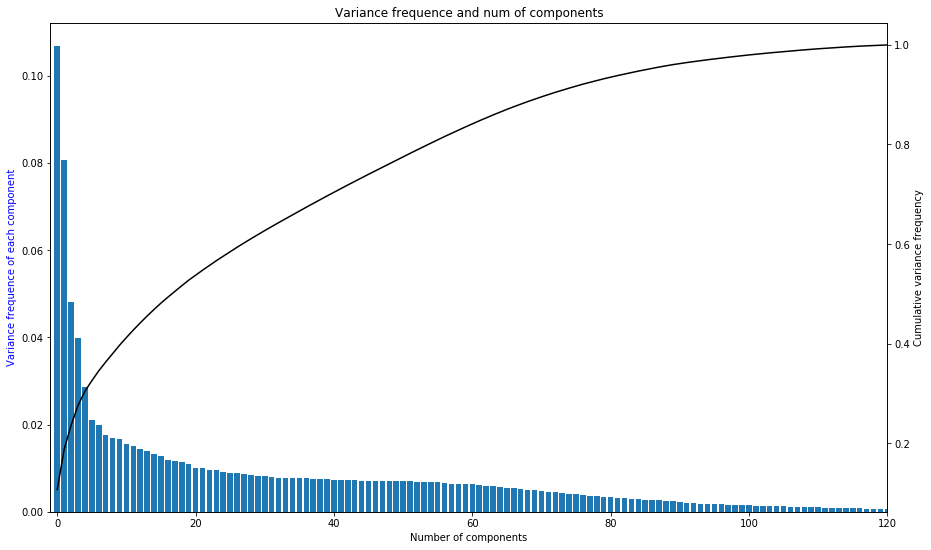

In [86]:
# Investigate the variance accounted for by each principal component.
# Ref: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html, see "explained_variance_ratio_" attribute.
pca_component_counts = len(pca.explained_variance_ratio_)
pca_component_counts_sequence = np.arange(pca_component_counts)

# Now we visualize the data:
# Ref: https://stackoverflow.com/questions/34162443/why-do-many-examples-use-fig-ax-plt-subplots-in-matplotlib-pyplot-python
# Ref: https://matplotlib.org/3.1.1/api/axes_api.html

fig, axe = plt.subplots(figsize=(15,9))

# Draw a bar plot: Ref: https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.axes.Axes.bar.html
axe.bar(pca_component_counts_sequence, pca.explained_variance_ratio_)
axe.set_xlabel('Number of components')
axe.set_ylabel('Variance frequence of each component', color = 'blue')
axe.set_xlim(-1, 120) # After running the code without this line, I found the chart would look better if we cut xlim.

# For cumulative patterns, we use the "numpy cumsum" function
# Ref: https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.cumsum.html
cumulative_variance_frequence = np.cumsum(pca.explained_variance_ratio_)

# Create double y axis:
# Ref: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.twinx.html
axe_2 = axe.twinx()

axe_2.plot(cumulative_variance_frequence, color = 'black')
axe_2.set_ylabel('Cumulative variance frequency', color = 'black')

plt.title("Variance frequence and num of components")

In [87]:
# We decide to use 0.9 cumulative frequency as a cutoff
# https://stackoverflow.com/questions/47797596/in-pandas-how-to-find-the-row-index-where-the-cumulative-sum-is-greater-than-a
cutoff_components = cumulative_variance_frequence.searchsorted(0.9)
cutoff_components #71

71

Text(0.5,1,'Variance frequence and num of components After cutoff')

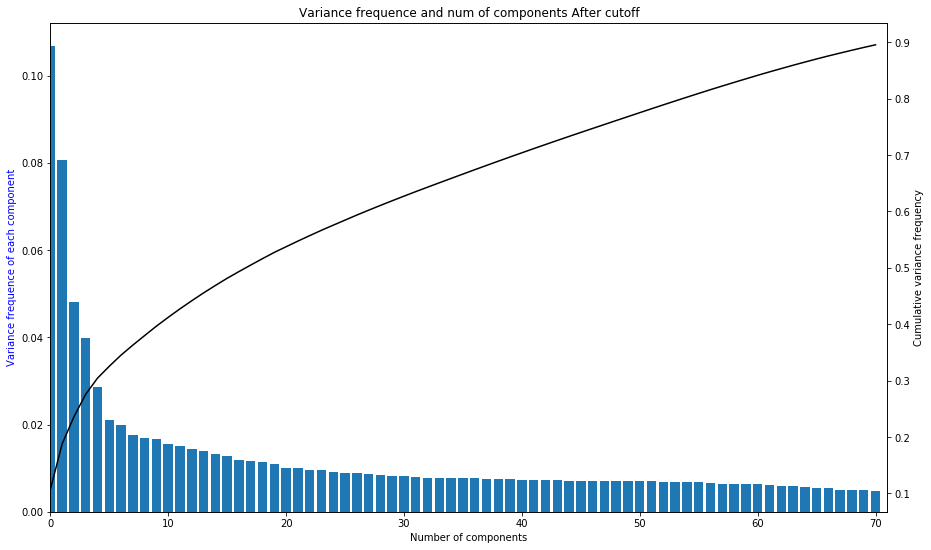

In [88]:
from sklearn.decomposition import PCA
# Re-apply PCA to the data while selecting for number of components to retain.
pca_71 = PCA(n_components = 71)
scaled_data_pca_71 = pca_71.fit_transform(scaled_data)

# Investigate again the variance accounted for by each new principal component.

#===========copy codes from above==================

# Ref: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html, see "explained_variance_ratio_" attribute.
pca_component_counts = len(pca_71.explained_variance_ratio_)
pca_component_counts_sequence = np.arange(pca_component_counts)

# Now we visualize the data:
# Ref: https://stackoverflow.com/questions/34162443/why-do-many-examples-use-fig-ax-plt-subplots-in-matplotlib-pyplot-python
# Ref: https://matplotlib.org/3.1.1/api/axes_api.html

fig, axe = plt.subplots(figsize=(15,9))

# Draw a bar plot: Ref: https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.axes.Axes.bar.html
axe.bar(pca_component_counts_sequence, pca_71.explained_variance_ratio_)
axe.set_xlabel('Number of components')
axe.set_ylabel('Variance frequence of each component', color = 'blue')
axe.set_xlim(0,71) # After running the code without this line, I found the chart would look better if we cut xlim.

# For cumulative patterns, we use the "numpy cumsum" function
# Ref: https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.cumsum.html
cumulative_variance_frequence = np.cumsum(pca_71.explained_variance_ratio_)

# Create double y axis:
# Ref: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.twinx.html
axe_2 = axe.twinx()

axe_2.plot(cumulative_variance_frequence, color = 'black')
axe_2.set_ylabel('Cumulative variance frequency', color = 'black')

plt.title("Variance frequence and num of components After cutoff")
#===========copy codes from above==================

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

After PCA analysis, we plot the frequency of variance explained of each component versus the number of components. A cutoff cumulative frequency of 0.9 was selected to help us get a better result in future analysis. This corresponded to 71 principle components (PC).
<br>
After that, I performed PCA analysis once again with those 71 PCs.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

Remember all the PCA analysis are based on "scaled_data":

In [89]:
scaled_data.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,new_PRA_JUG_dec,new_PRA_JUG_mov,new_CAMEO_INTL_weal,new_CAMEO_INTL_life
0,-1.747634,0.975423,-1.523655,1.588878,-1.050212,1.513292,1.048651,1.341142,-0.542999,1.038860,...,-0.233441,-0.350043,-0.272691,0.37941,-0.303319,-0.208305,1.135113,0.767724,1.174786,-1.247917
1,0.193497,0.975423,-1.523655,0.908468,-1.771419,-0.548762,0.320698,1.341142,1.841624,1.038860,...,-0.233441,-0.350043,-0.272691,0.37941,-0.303319,-0.208305,1.641771,-1.302552,-0.854108,0.752917
2,0.193497,-1.025197,0.677626,0.228057,0.392200,-1.236113,0.320698,-0.834925,-0.542999,1.038860,...,-0.233441,-0.350043,-0.272691,0.37941,-0.303319,-0.208305,-0.384863,0.767724,0.498488,0.085973
3,-1.747634,0.975423,-0.056134,-1.132765,1.113406,-0.548762,-0.407255,1.341142,-0.542999,1.038860,...,-0.233441,-0.350043,-0.272691,0.37941,-0.303319,-0.208305,-1.398181,-1.302552,1.174786,0.752917
4,-0.777068,0.975423,-1.523655,1.588878,-1.771419,1.513292,1.048651,-0.109569,-0.542999,-0.285764,...,-0.233441,-0.350043,-0.272691,0.37941,-0.303319,-0.208305,0.121795,0.767724,-0.854108,-0.580972


In [90]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# We make use of the ".components_" attribute:
# Ref: https://stats.stackexchange.com/questions/311908/what-is-pca-components-in-sk-learn
pca_71.components_[0]

array([ -9.96343862e-02,   9.39276342e-03,  -1.94390335e-01,
         1.23043408e-01,  -9.49727052e-02,   5.64561169e-02,
         6.50038519e-02,   1.41780550e-01,  -9.85730815e-02,
         2.57506089e-02,  -1.51381607e-01,  -1.36921940e-01,
        -1.93560652e-02,   2.87839078e-02,   5.80513595e-02,
         8.40628851e-02,   6.48558191e-02,  -3.51065122e-02,
        -7.08786120e-02,  -6.41350303e-02,   5.19046390e-02,
         7.78315923e-02,   1.58200942e-02,   2.29250554e-02,
         3.29305632e-02,   8.97581755e-02,   7.65475668e-02,
        -2.29815286e-03,   1.97048439e-02,  -1.01314088e-01,
        -5.46838026e-03,   1.78461037e-01,   4.43770519e-02,
        -6.40689638e-02,   1.14307823e-01,   2.69602686e-02,
        -1.35080776e-01,  -4.64214037e-02,  -6.72590852e-02,
        -1.89204527e-01,   1.30619849e-02,   1.15279117e-01,
         1.26128273e-01,  -1.80797298e-01,  -9.81952093e-02,
         1.54344163e-01,  -1.28161754e-01,  -9.65710424e-02,
         4.93072436e-02,

-----we can run the following for short!------

In [92]:
def get_pca_dataframe(less_nan_encoded_combined):
    # Replace all NaNs with zeros:
    # Make a copy of the original "less_nan_encoded_combined" dataset
    less_nan_encoded_combined_2 = less_nan_encoded_combined.copy()

    # Fill na with 0:
    less_nan_encoded_combined_2.fillna(0, inplace=True)

    object_data = []
    for i in less_nan_encoded_combined_2.columns:
        if less_nan_encoded_combined_2[i].dtype == np.object:
              object_data.append(i)

    less_nan_encoded_combined_2_dropped = less_nan_encoded_combined_2.copy()
    less_nan_encoded_combined_2_dropped.drop(['CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], axis=1, inplace=True) 

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaled_less_nan_encoded_combined_2_dropped = scaler.fit_transform(less_nan_encoded_combined_2_dropped)
    scaled_less_nan_encoded_combined_2_dropped = pd.DataFrame(scaled_less_nan_encoded_combined_2_dropped)

    # Add column names:
    scaled_less_nan_encoded_combined_2_dropped.columns = less_nan_encoded_combined_2_dropped.columns

    scaled_data = scaled_less_nan_encoded_combined_2_dropped.copy()

    return scaled_data

#scaled_data = get_pca_dataframe(less_nan_encoded_combined)

def pca(scaled_data, cutoff_value):
    # Apply PCA to the data.
    from sklearn.decomposition import PCA

    pca = PCA()
    scaled_data_pca = pca.fit_transform(scaled_data)
    cumulative_variance_frequence = np.cumsum(pca.explained_variance_ratio_)

    cutoff_components = cumulative_variance_frequence.searchsorted(cutoff_value)

    # Second PCA:
    
    pca_71 = PCA(n_components = cutoff_components)
    scaled_data_pca_71 = pca_71.fit_transform(scaled_data)
    
    return pca_71, scaled_data_pca_71

#pca_71, scaled_data_pca_71 = pca(scaled_data, cutoff_value = 0.9)

def single_column_pca(PC_axis,pca_71,scaled_data):
    
    df = pd.DataFrame(pca_71.components_[PC_axis - 1])
    df.index = scaled_data.columns    
    df.columns=[f"PC-{PC_axis}"]
    df = df.sort_values(by = [f"PC-{PC_axis}"], ascending=False)

    return df

#single_column_pca(PC_axis = 1)

In [93]:
def combined_pca_matrix(pca_71, scaled_data_pca_71):
    df = pd.DataFrame(scaled_data_pca_71)
    df.columns = [f"PC-{i}" for i in range(1, len(pca_71.components_) + 1)]
    return df

-----end of short-------

In [94]:
scaled_data = get_pca_dataframe(less_nan_encoded_combined)
pca_71, scaled_data_pca_71 = pca(scaled_data, cutoff_value = 0.9)

In [95]:
single_column_pca(1, pca_71,scaled_data).head()

,PC-1
LP_STATUS_GROB_1.0,0.192881
PLZ8_ANTG3,0.180276
HH_EINKOMMEN_SCORE,0.178461
PLZ8_ANTG4,0.175248
PLZ8_BAUMAX,0.171236


In [97]:
pca_matrix = combined_pca_matrix(pca_71, scaled_data_pca_71)
pca_matrix.head()

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,...,PC-62,PC-63,PC-64,PC-65,PC-66,PC-67,PC-68,PC-69,PC-70,PC-71
0,4.311611,-4.051400,-3.355583,1.456939,0.643718,1.861752,-1.159854,1.327469,1.621045,1.563728,...,-2.887215,2.182427,0.256248,-1.871969,1.235800,-1.356630,-0.119345,1.289523,0.666230,1.080884
1,0.564856,-0.249853,-3.432947,-1.250522,-3.867949,1.503811,-1.636030,-0.245057,-0.496149,-1.405132,...,-0.268202,0.276467,-0.108587,0.300972,1.054261,-0.180303,0.548983,-0.094610,0.613458,2.256338
2,-0.629054,-0.018492,3.282988,3.468754,1.392769,0.044946,-2.918670,-0.414706,-0.073078,-3.552798,...,0.557767,0.376232,0.643804,-0.088084,1.289938,-0.374689,0.635937,0.172366,-0.266285,0.148894
3,-0.897067,-0.915075,-1.267247,-4.279684,-0.047749,2.079707,-2.941013,-0.614914,1.087490,0.476335,...,0.390585,-1.523951,0.042492,-0.428045,0.872923,0.505329,0.602018,0.221506,0.201967,0.557464
4,1.735523,-3.746173,-3.251889,-2.676883,-1.447902,-0.853565,-0.934429,-1.044669,0.653880,0.638955,...,0.158350,0.097087,1.318081,-1.471146,0.676885,-1.075779,-1.242995,-0.063117,-0.232124,-0.242838


#### Map weights for the 1st principal component

In [98]:
single_column_pca(1, pca_71,scaled_data).head()

,PC-1
LP_STATUS_GROB_1.0,0.192881
PLZ8_ANTG3,0.180276
HH_EINKOMMEN_SCORE,0.178461
PLZ8_ANTG4,0.175248
PLZ8_BAUMAX,0.171236


In [99]:
# Print feature name corresponding to greatest importance in explaing this PC:
single_column_pca(1, pca_71,scaled_data).iloc[0,] #Name: LP_STATUS_GROB_1.0, dtype: float64

PC-1    0.192881
Name: LP_STATUS_GROB_1.0, dtype: float64

In [100]:
single_column_pca(1, pca_71,scaled_data).tail()

,PC-1
PLZ8_ANTG1,-0.180223
KBA05_GBZ,-0.180797
KBA05_ANTG1,-0.189205
FINANZ_MINIMALIST,-0.194390
MOBI_REGIO,-0.203061


In [101]:
# Print feature name corresponding to lowest importance in explaing this PC:
single_column_pca(1, pca_71,scaled_data).iloc[-1,] #Name: MOBI_REGIO, dtype: float64

PC-1   -0.203061
Name: MOBI_REGIO, dtype: float64

#### Map weights for the 2nd principal component

In [102]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
single_column_pca(2, pca_71,scaled_data).head()

,PC-2
ALTERSKATEGORIE_GROB,0.229695
FINANZ_VORSORGER,0.210145
ZABEOTYP_3.0,0.197765
SEMIO_ERL,0.181890
SEMIO_LUST,0.160839


In [103]:
# Print feature name corresponding to greatest importance in explaing this PC:
single_column_pca(2, pca_71,scaled_data).iloc[0,] #Name: ALTERSKATEGORIE_GROB, dtype: float64

PC-2    0.229695
Name: ALTERSKATEGORIE_GROB, dtype: float64

In [104]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
single_column_pca(2, pca_71,scaled_data).tail()

,PC-2
SEMIO_PFLICHT,-0.204732
FINANZ_UNAUFFAELLIGER,-0.206389
SEMIO_REL,-0.215971
FINANZ_SPARER,-0.219094
new_PRA_JUG_dec,-0.234124


In [105]:
# Print feature name corresponding to greatest importance in explaing this PC:
single_column_pca(2, pca_71,scaled_data).iloc[-1,] #Name: new_PRA_JUG_dec, dtype: float64

PC-2   -0.234124
Name: new_PRA_JUG_dec, dtype: float64

#### Map weights for the 3rd principal component

In [106]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
single_column_pca(3, pca_71,scaled_data).head()

,PC-3
SEMIO_VERT,0.324170
SEMIO_FAM,0.261193
SEMIO_SOZ,0.258279
SEMIO_KULT,0.249990
FINANZTYP_5.0,0.134575


In [107]:
# Print feature name corresponding to greatest importance in explaing this PC:
single_column_pca(3, pca_71,scaled_data).iloc[0,] #Name: SEMIO_VERT, dtype: float64

PC-3    0.32417
Name: SEMIO_VERT, dtype: float64

In [108]:
single_column_pca(3, pca_71,scaled_data).tail()

,PC-3
SEMIO_ERL,-0.201422
SEMIO_KRIT,-0.264118
SEMIO_DOM,-0.285355
SEMIO_KAEM,-0.317692
ANREDE_KZ,-0.347703


In [109]:
# Print feature name corresponding to greatest importance in explaing this PC:
single_column_pca(3, pca_71,scaled_data).iloc[-1,] #Name: ANREDE_KZ, dtype: float64

PC-3   -0.347703
Name: ANREDE_KZ, dtype: float64

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

For interpretation of these data, we looked through Data_Dictionary.md to find out what these features represent.
<br><br>
**For PC-1:**
<br><br>
Positive correlation:
<br>
- LP_STATUS_GROB_1.0, PLZ8_ANTG3 have the largest positive feature weights.
- LP_STATUS_GROB_1.0 stands for Social status (1.0 stands for low-income earners), while PLZ8_ANTG3 stands for Number of 6-10 family houses in the PLZ8 region.
- These two features ranked as two largest positive features, meaning they are highly positively correlated. 
- This highly positively correlated pattern means that the lower income one earns, the higher number of 6-10 family houses they possess. 
- I think this may due to that if one earns very low, he has to share houses with others, which actually makes sense.
<br><br>

Negative correlation:
<br>
- MOBI_REGIO, FINANZ_MINIMALIST have the largest negative feature weights.
- MOBI_REGIO stands for Movement patterns (the higher the value, the lower the movement (Data_Dictionary.md)), while FINANZ_MINIMALIST stands for Financial typology, MINIMALIST means low financial interest.
- These two features ranked as two largest negative features, meaning they are highly negatively correlated. 
- This highly negatively correlated pattern means that the lower the movement, the lower financial interest. 
- I think this may due to that if one moves less frequently, he may be very poor, thus he has litter interest in finance, or to invest his money.

**For PC-2:** 
<br><br>
Positive correlation:
<br>
- ALTERSKATEGORIE_GROB, FINANZ_VORSORGER have the largest positive feature weights.
- ALTERSKATEGORIE_GROB stands for Estimated age based on given name analysis (higher means older), while FINANZ_VORSORGER stands for Financial typology, VORSORGER means "be prepared".
- These two features ranked as two largest positive features, meaning they are highly positively correlated. 
- This highly positively correlated pattern means that the older one is, the higher higher tendency for them to get prepared for investing. 
- I think that between certain range of age, this is true. For example, adults who have worked for many years has more money than those who just get to work, thus they are more likely to get prepared for investing.
<br><br>

Negative correlation:
<br>
- new_PRA_JUG_dec, FINANZ_SPARER have the largest negative feature weights.
- new_PRA_JUG_dec (PRAEGENDE_JUGENDJAHRE) stands for Dominating movement of person's youth (the higher the value, the younger), while FINANZ_SPARER stands for Financial typology, SPARER means money-saver.
- These two features ranked as two largest negative features, meaning they are highly negatively correlated. 
- This highly negatively correlated pattern means that the younger a person, the less willingness for him to invest. 
- I think this makes sense, young people are more likely to spend money instead of invest.

**For PC-3:** 
<br><br>
Positive correlation:
<br>
- FINANZTYP_5.0, SEMIO_KULT have the largest positive feature weights.
- FINANZTYP_5.0 stands for Most descriptive financial type for individual (higher means more likely to invest), while SEMIO_KULT stands for Personality typology, KULT means cultural-minded (higher means lowest affinity).
- These two features ranked as two largest positive features, meaning they are highly positively correlated. 
- This highly positively correlated pattern means that if a person is more likely to invest, he is also more likely to stay away from people and stand alone. 
- I think that although some kinds of weird, this may be true. A person with a high tendency to invest may be a highly-educated person, who may look down on the ordinary people, thus keeping himself alone to maintain his dignity.
<br><br>

Negative correlation:
<br>
- ANREDE_KZ, SEMIO_KAEM have the largest negative feature weights.
- ANREDE_KZ is gender (2 for female, 1 for male), while SEMIO_KAEM stands for Personality typology, KAEM means combative attitude.
- These two features ranked as two largest negative features, meaning they are highly negatively correlated. 
- This highly negatively correlated pattern means that female would act less combatively. 
- I think this quite makes sense, females are not as combative and competitive as males in many cases.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [110]:
# review
#pca_71 = PCA(n_components = 71)
#scaled_data_pca_71 = pca.fit_transform(scaled_data)

In [111]:
scaled_data_pca_71

array([[ 4.31161069, -4.05139999, -3.35558305, ...,  1.28952265,
         0.66623034,  1.08088373],
       [ 0.56485575, -0.24985342, -3.43294674, ..., -0.09460954,
         0.61345792,  2.25633843],
       [-0.62905387, -0.01849238,  3.28298777, ...,  0.17236572,
        -0.26628487,  0.14889375],
       ..., 
       [ 0.41984589, -2.45128242, -4.67478236, ..., -0.4294885 ,
         1.62188035, -0.23658819],
       [ 5.80501505, -4.52159239,  2.71081769, ..., -0.81203258,
        -1.58769031,  0.1302993 ],
       [ 0.74597471,  2.70173803,  2.13927113, ..., -0.84984296,
         0.14678038,  0.07807963]])

In [112]:
pca_71.explained_variance_ratio_[0]

0.10682199214917691

In [113]:
pca_71.components_[0]

array([ -9.96343863e-02,   9.39276203e-03,  -1.94390335e-01,
         1.23043408e-01,  -9.49727062e-02,   5.64561176e-02,
         6.50038531e-02,   1.41780552e-01,  -9.85730844e-02,
         2.57506104e-02,  -1.51381607e-01,  -1.36921940e-01,
        -1.93560592e-02,   2.87838997e-02,   5.80513592e-02,
         8.40628841e-02,   6.48558219e-02,  -3.51065116e-02,
        -7.08786172e-02,  -6.41350319e-02,   5.19046398e-02,
         7.78315937e-02,   1.58200941e-02,   2.29250545e-02,
         3.29305611e-02,   8.97581706e-02,   7.65475649e-02,
        -2.29815406e-03,   1.97048443e-02,  -1.01314088e-01,
        -5.46837723e-03,   1.78461031e-01,   4.43770643e-02,
        -6.40689609e-02,   1.14307815e-01,   2.69602739e-02,
        -1.35080779e-01,  -4.64214036e-02,  -6.72590813e-02,
        -1.89204527e-01,   1.30619863e-02,   1.15279114e-01,
         1.26128278e-01,  -1.80797303e-01,  -9.81952128e-02,
         1.54344162e-01,  -1.28161751e-01,  -9.65710401e-02,
         4.93072454e-02,

In [114]:
pca_71_matrix = pd.DataFrame(scaled_data_pca_71)
pca_71_matrix.columns = [f"PC-{i}" for i in range(1, len(pca_71.components_) + 1)]

In [115]:
pca_71_matrix.shape
#(684502, 71)

(684502, 71)

In [116]:
# perform k-means clustering on the PCA-transformed data
# Over a number of different cluster counts...
# The objective in the K-means is to reduce the sum of squares of the distances (SSD) of points from their respective cluster centroids. 
# Ref: Understanding the "score"in Kmeans
# https://stackoverflow.com/questions/32370543/understanding-score-returned-by-scikit-learn-kmeans

from sklearn.cluster import KMeans

def get_parameters_Km(pca_transformed_dataframe, num_cluster):
    '''
    Input: pca_transformed_dataframe, number of clusters ready to plot
    Output: 3 list variables, number of clusters, SSD values from K-Means Objective values (model.inertia_ ) and values of .score.
    '''
    
    n_cluster = []
    ssd = []

    # run k-means clustering on the data and...
    for i in range(2, num_cluster + 1):
        # create Kmeans instance
        km = KMeans(n_clusters = i, max_iter = 100)
        km_fitted = km.fit(pca_transformed_dataframe)
        
        # compute the average within-cluster distances.
        n_cluster.append(i)
        ssd.append(km_fitted.inertia_)
    
    return n_cluster, ssd

In [117]:
n_cluster, ssd = get_parameters_Km(pca_71_matrix.iloc[:10000,], num_cluster = 20)

Text(0.5,1,'SSD versus Number of cluster on 10000 rows')

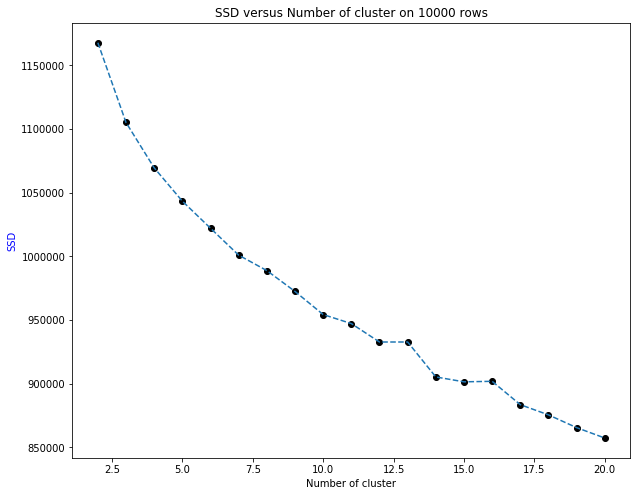

In [118]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

fig, axe = plt.subplots(figsize = (10, 8))

# ax.plot(x_variable, y_variable, line_type)
axe.scatter(n_cluster,ssd, color="black")
axe.plot(n_cluster,ssd,'--')
axe.set_xlabel('Number of cluster')
axe.set_ylabel('SSD', color = 'blue')

plt.title("SSD versus Number of cluster on 10000 rows")

In [152]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

km_optimal = KMeans(n_clusters = 15, max_iter = 100)
km_fitted_optimal_model = km_optimal.fit(pca_71_matrix.iloc[:10000,])

# return the label index of each row calculated by k means
labels_general = km_fitted_optimal_model.labels_


In [120]:
len(labels_general)

10000

In [153]:
# Add labels to the original matrix:
sliced_pca_71_matrix = pca_71_matrix.iloc[:10000,]
sliced_pca_71_matrix["k means labels"] = labels_general

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [154]:
sliced_pca_71_matrix.head()

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,...,PC-63,PC-64,PC-65,PC-66,PC-67,PC-68,PC-69,PC-70,PC-71,k means labels
0,4.311611,-4.051400,-3.355583,1.456939,0.643718,1.861752,-1.159854,1.327469,1.621045,1.563728,...,2.182427,0.256248,-1.871969,1.235800,-1.356630,-0.119345,1.289523,0.666230,1.080884,13
1,0.564856,-0.249853,-3.432947,-1.250522,-3.867949,1.503811,-1.636030,-0.245057,-0.496149,-1.405132,...,0.276467,-0.108587,0.300972,1.054261,-0.180303,0.548983,-0.094610,0.613458,2.256338,3
2,-0.629054,-0.018492,3.282988,3.468754,1.392769,0.044946,-2.918670,-0.414706,-0.073078,-3.552798,...,0.376232,0.643804,-0.088084,1.289938,-0.374689,0.635937,0.172366,-0.266285,0.148894,3
3,-0.897067,-0.915075,-1.267247,-4.279684,-0.047749,2.079707,-2.941013,-0.614914,1.087490,0.476335,...,-1.523951,0.042492,-0.428045,0.872923,0.505329,0.602018,0.221506,0.201967,0.557464,2
4,1.735523,-3.746173,-3.251889,-2.676883,-1.447902,-0.853565,-0.934429,-1.044669,0.653880,0.638955,...,0.097087,1.318081,-1.471146,0.676885,-1.075779,-1.242995,-0.063117,-0.232124,-0.242838,12


In [35]:
#(Optional)
# I can also predict on new data:
# ref: https://www.dummies.com/programming/big-data/data-science/how-to-evaluate-an-unsupervised-learning-model-with-k-means/
# predicted_labels = km_fitted_optimal_model.predict(some_new_dataframe.iloc[:10000,])

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

Using an elbow method, we visually determined that the optimal k cluster is 15, 
<br>see Ref: https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [123]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=";")

In [124]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [127]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_cleaned = clean_data(customers)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [128]:
customers_cleaned.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,FINANZTYP_5.0,FINANZTYP_6.0,new_PRA_JUG_dec,new_PRA_JUG_mov,new_CAMEO_INTL_weal,new_CAMEO_INTL_life
0,2.0,4.0,1.0,5.0,5.0,1.0,5.0,1.0,2.0,2.0,...,0,1,0,0,0,0,2.0,1.0,1.0,3.0
2,NaN,4.0,2.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,...,0,1,0,0,0,0,2.0,1.0,3.0,4.0
3,1.0,4.0,1.0,2.0,5.0,1.0,5.0,2.0,1.0,2.0,...,0,0,0,0,0,1,1.0,0.0,2.0,4.0
4,NaN,3.0,1.0,6.0,3.0,1.0,4.0,4.0,5.0,2.0,...,0,1,0,0,0,0,4.0,1.0,4.0,1.0
5,1.0,3.0,1.0,4.0,5.0,1.0,5.0,1.0,2.0,3.0,...,0,0,0,0,1,0,2.0,1.0,3.0,4.0


In [129]:
scaled_data_customers1 = get_pca_dataframe(customers_cleaned)

pca_customers3, scaled_data_pca_customers2 = pca(scaled_data_customers1, cutoff_value = 0.9)

pca_matrix_customers = combined_pca_matrix(pca_customers3, scaled_data_pca_customers2)

In [130]:
single_column_pca(1, pca_customers3, scaled_data_customers1).head()

#FINANZ_HAUSBAUER	0.208660
#HH_EINKOMMEN_SCORE	0.184421
#PLZ8_BAUMAX	0.174562
#PLZ8_ANTG3	0.171443
#PLZ8_ANTG4	0.169672

,PC-1
FINANZ_HAUSBAUER,0.208660
HH_EINKOMMEN_SCORE,0.184421
PLZ8_BAUMAX,0.174562
PLZ8_ANTG3,0.171443
PLZ8_ANTG4,0.169672


In [131]:
pca_matrix_customers.head()

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,...,PC-41,PC-42,PC-43,PC-44,PC-45,PC-46,PC-47,PC-48,PC-49,PC-50
0,-3.178623,-3.415757,0.668269,2.255450,-0.653798,-0.418426,-0.923491,3.050697,-1.247403,0.341815,...,1.682353,-0.589552,0.910993,-0.921759,0.027956,1.030635,-0.822941,0.379966,0.066537,0.027336
1,3.438618,-2.590830,-2.546456,-0.503098,0.633686,-2.564409,-1.480986,-0.682890,-1.215555,1.435323,...,-0.648310,0.676149,0.402696,-0.504929,-1.055773,0.010252,1.015760,-0.261739,0.374996,0.072425
2,-1.921160,-1.092445,-0.225767,3.767836,-3.685883,0.961036,0.587539,-0.700177,0.755777,-0.660893,...,-0.986699,-0.862689,-0.944351,-0.867163,1.549068,-0.958488,0.378527,0.250380,-0.579945,0.621727
3,1.091844,4.607997,1.570423,-1.177480,0.593828,2.606494,0.649511,-0.268312,-3.106423,1.813270,...,-0.382640,1.095815,-1.183895,0.639580,-1.085221,-1.068273,0.224223,-1.539292,-0.255404,0.391451
4,-0.067548,-0.794478,2.048507,-1.772310,-1.757877,-2.265810,1.118264,0.418941,-0.220415,0.589473,...,-1.420182,-0.298929,0.237623,-0.628502,-1.160729,-0.097209,0.503894,-0.905567,0.047809,0.327422


--------Now we perform clustering--------

In [132]:
n_cluster_customers, ssd_customers = get_parameters_Km(pca_matrix_customers.iloc[:10000,], num_cluster = 20)

Text(0.5,1,'Customer data: SSD versus Number of cluster on 10000 rows')

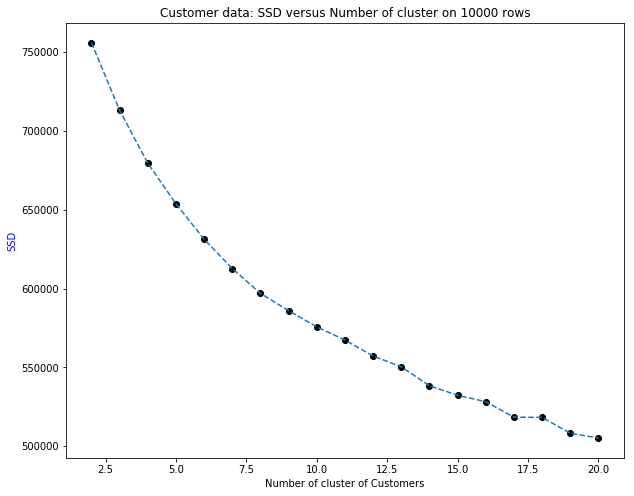

In [133]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

fig, axe = plt.subplots(figsize = (10, 8))

# ax.plot(x_variable, y_variable, line_type)
axe.scatter(n_cluster_customers, ssd_customers, color="black")
axe.plot(n_cluster_customers, ssd_customers,'--')
axe.set_xlabel('Number of cluster of Customers')
axe.set_ylabel('SSD', color = 'blue')

plt.title("Customer data: SSD versus Number of cluster on 10000 rows")

We can see that the curve is similar to the population data before

--------Now we perform clustering, again we choose 15 clusters---------

In [134]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

km_optimal = KMeans(n_clusters = 15, max_iter = 100)
km_fitted_optimal_model = km_optimal.fit(pca_matrix_customers.iloc[:10000,])

# return the label index of each row calculated by k means
labels_customer = km_fitted_optimal_model.labels_

# Add labels to the original matrix:
sliced_pca_matrix_customers = pca_matrix_customers.iloc[:10000,]
sliced_pca_matrix_customers["k means labels"] = labels_customer

sliced_pca_matrix_customers.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,...,PC-42,PC-43,PC-44,PC-45,PC-46,PC-47,PC-48,PC-49,PC-50,k means labels
0,-3.178623,-3.415757,0.668269,2.255450,-0.653798,-0.418426,-0.923491,3.050697,-1.247403,0.341815,...,-0.589552,0.910993,-0.921759,0.027956,1.030635,-0.822941,0.379966,0.066537,0.027336,6
1,3.438618,-2.590830,-2.546456,-0.503098,0.633686,-2.564409,-1.480986,-0.682890,-1.215555,1.435323,...,0.676149,0.402696,-0.504929,-1.055773,0.010252,1.015760,-0.261739,0.374996,0.072425,4
2,-1.921160,-1.092445,-0.225767,3.767836,-3.685883,0.961036,0.587539,-0.700177,0.755777,-0.660893,...,-0.862689,-0.944351,-0.867163,1.549068,-0.958488,0.378527,0.250380,-0.579945,0.621727,6
3,1.091844,4.607997,1.570423,-1.177480,0.593828,2.606494,0.649511,-0.268312,-3.106423,1.813270,...,1.095815,-1.183895,0.639580,-1.085221,-1.068273,0.224223,-1.539292,-0.255404,0.391451,2
4,-0.067548,-0.794478,2.048507,-1.772310,-1.757877,-2.265810,1.118264,0.418941,-0.220415,0.589473,...,-0.298929,0.237623,-0.628502,-1.160729,-0.097209,0.503894,-0.905567,0.047809,0.327422,13


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

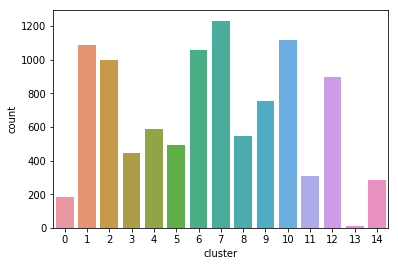

In [135]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

import seaborn as sns
# We get two labels, "labels_general" and "labels_customer", now lets compare their distributions

# Distribution of genaral population
labels1 = pd.DataFrame(labels_general)
labels1.columns = ['cluster']

sns.countplot( x = 'cluster', data = labels1)

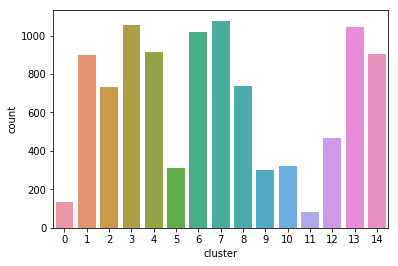

In [136]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

import seaborn as sns
# We get two labels, "labels_general" and "labels_customer", now lets compare their distributions

# Distribution of customers
labels2 = pd.DataFrame(labels_customer)
labels2.columns = ['cluster']

sns.countplot( x = 'cluster', data = labels2)

In [155]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Cluster 13 is overrepresented in the customer data than the population data
labels2['cluster'].value_counts()

7     1077
3     1056
13    1042
6     1020
4      914
14     902
1      897
8      740
2      734
12     468
10     324
5      311
9      299
0      134
11      82
Name: cluster, dtype: int64

In [139]:
labels1['cluster'].value_counts()

7     1232
10    1115
1     1090
6     1060
2      998
12     900
9      754
4      585
8      545
5      490
3      443
11     311
14     285
0      182
13      10
Name: cluster, dtype: int64

In [156]:
# Because we are only working on 10000 rows of data, we print the percentage
# cluster 13 has 1042 counts
print ("customer data top cluster has a ratio of ", 1042 / 10000, "in total entries")

customer data top cluster has a ratio of  0.1042 in total entries


In [157]:
# In general data, cluster 13 has 10 counts
print ("general data top cluster has a ratio of ", 10 / 10000, "in total entries")

general data top cluster has a ratio of  0.001 in total entries


In [158]:
# First we add row names to each columns:
# We have two pca transformed dataframes: "sliced_pca_matrix_customers" and "sliced_pca_71_matrix"
#and two original columns ("azdias" and "customer"). We now combine the original columns with the labels we get here:
less_nan_encoded_combined['km label'] = labels1
customers_cleaned['km label'] = labels2

In [162]:
# Then we find out what kinds of people are the most in cluster 13 in the customer data:
customer_cluster13 = customers_cleaned.loc[customers_cleaned['km label'] == 13,:]
customer_cluster13.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,FINANZTYP_5.0,FINANZTYP_6.0,new_PRA_JUG_dec,new_PRA_JUG_mov,new_CAMEO_INTL_weal,new_CAMEO_INTL_life,km label
4,NaN,3.0,1.0,6.0,3.0,1.0,4.0,4.0,5.0,2.0,...,1,0,0,0,0,4.0,1.0,4.0,1.0,13.0
6,2.0,4.0,1.0,2.0,5.0,1.0,5.0,1.0,1.0,2.0,...,1,0,0,0,0,2.0,1.0,2.0,3.0,13.0
10,NaN,3.0,2.0,5.0,4.0,2.0,4.0,4.0,3.0,1.0,...,0,0,0,0,1,4.0,1.0,NaN,NaN,13.0
49,NaN,2.0,1.0,4.0,4.0,3.0,1.0,5.0,5.0,1.0,...,0,1,0,0,0,5.0,1.0,1.0,5.0,13.0
63,2.0,3.0,1.0,3.0,5.0,1.0,5.0,1.0,2.0,2.0,...,1,0,0,0,0,3.0,0.0,2.0,5.0,13.0


In [160]:
# Print what kinds of people are the most in each column:
customer_cluster13_slice = customer_cluster13.copy()
customer_cluster13_slice = customer_cluster13_slice.iloc[:,1:96]
for col in customer_cluster13_slice.columns:
    print(customer_cluster13_slice[col].value_counts())

4.0    469
3.0    242
2.0     33
1.0     25
Name: ALTERSKATEGORIE_GROB, dtype: int64
1.0    503
2.0    269
Name: ANREDE_KZ, dtype: int64
2.0    211
4.0    142
3.0    132
1.0    130
5.0     80
6.0     57
Name: CJT_GESAMTTYP, dtype: int64
5.0    433
4.0    152
3.0    104
2.0     72
1.0     11
Name: FINANZ_MINIMALIST, dtype: int64
1.0    549
2.0    128
3.0     54
4.0     26
5.0     15
Name: FINANZ_SPARER, dtype: int64
5.0    544
4.0    148
3.0     43
2.0     20
1.0     17
Name: FINANZ_VORSORGER, dtype: int64
1.0    484
2.0    153
3.0     64
4.0     47
5.0     24
Name: FINANZ_ANLEGER, dtype: int64
1.0    338
2.0    260
3.0    115
5.0     31
4.0     28
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
2.0    262
5.0    141
3.0    138
1.0    135
4.0     96
Name: FINANZ_HAUSBAUER, dtype: int64
1940.0    18
1946.0    17
1937.0    17
1941.0    17
1942.0    16
1939.0    15
1950.0    14
1943.0    13
1938.0    13
1932.0    13
1948.0    13
1964.0    12
1963.0    12
1954.0    12
1949.0    12
1959.0    12
19

In [163]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Cluster 10 is underrepresented in the customer data
labels2['cluster'].value_counts()

7     1077
3     1056
13    1042
6     1020
4      914
14     902
1      897
8      740
2      734
12     468
10     324
5      311
9      299
0      134
11      82
Name: cluster, dtype: int64

In [164]:
# Then we find out what kinds of people are the most in cluster 11 in the customer data:
customer_cluster10 = customers_cleaned.loc[customers_cleaned['km label'] == 10,:]
customer_cluster10.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,FINANZTYP_5.0,FINANZTYP_6.0,new_PRA_JUG_dec,new_PRA_JUG_mov,new_CAMEO_INTL_weal,new_CAMEO_INTL_life,km label
12,NaN,4.0,1.0,5.0,5.0,2.0,4.0,3.0,2.0,1.0,...,0,0,0,0,1,4.0,1.0,2.0,2.0,10.0
16,1.0,4.0,1.0,2.0,5.0,1.0,5.0,1.0,3.0,2.0,...,0,0,0,1,0,2.0,1.0,1.0,5.0,10.0
19,NaN,4.0,2.0,4.0,3.0,2.0,4.0,3.0,3.0,3.0,...,1,0,0,0,0,4.0,1.0,2.0,4.0,10.0
41,2.0,4.0,2.0,2.0,4.0,1.0,5.0,1.0,2.0,3.0,...,1,0,0,0,0,2.0,1.0,2.0,4.0,10.0
47,NaN,3.0,2.0,3.0,4.0,2.0,4.0,4.0,1.0,1.0,...,0,0,0,0,1,6.0,0.0,4.0,3.0,10.0


In [165]:
# Print what kinds of people are the most in each column:
customer_cluster10_slice = customer_cluster10.copy()
customer_cluster10_slice = customer_cluster10_slice.iloc[:,1:96]
for col in customer_cluster10_slice.columns:
    print(customer_cluster10_slice[col].value_counts())

4.0    142
3.0     74
1.0     11
2.0      9
Name: ALTERSKATEGORIE_GROB, dtype: int64
1.0    137
2.0     99
Name: ANREDE_KZ, dtype: int64
2.0    76
4.0    40
3.0    39
1.0    34
5.0    29
6.0    16
Name: CJT_GESAMTTYP, dtype: int64
5.0    117
4.0     53
3.0     37
2.0     25
1.0      4
Name: FINANZ_MINIMALIST, dtype: int64
1.0    175
2.0     38
4.0     14
3.0      8
5.0      1
Name: FINANZ_SPARER, dtype: int64
5.0    174
4.0     36
2.0      9
3.0      9
1.0      8
Name: FINANZ_VORSORGER, dtype: int64
1.0    155
2.0     35
4.0     18
3.0     18
5.0     10
Name: FINANZ_ANLEGER, dtype: int64
1.0    116
2.0     72
3.0     28
5.0     12
4.0      8
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
2.0    69
3.0    55
5.0    45
4.0    38
1.0    29
Name: FINANZ_HAUSBAUER, dtype: int64
1940.0    12
1941.0    11
1928.0     8
1943.0     8
1938.0     7
1942.0     7
1936.0     6
1944.0     5
1953.0     5
1939.0     5
1937.0     5
1952.0     5
1950.0     5
1933.0     4
1948.0     3
1957.0     3
1961.0     3


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

First, let's look at the customer PCA data.
"FINANZ_HAUSBAUER" and "HH_EINKOMMEN_SCORE" are the top 2 category that are strongly positively related with each other. Then we move to cluster 13(overrepresented in customer data), and we found that FINANZ_HAUSBAUER has top records of "2.0", while HH_EINKOMMEN_SCORE has top entries of "1.0". When we move to cluster 10 (underrepresented in customer data), we found that FINANZ_HAUSBAUER has top records of "2.0", while HH_EINKOMMEN_SCORE has top records of "1.0". FINANZ_HAUSBAUER defines the financial typology, and HAUSBAUER stands for home ownership. HH_EINKOMMEN_SCORE is the estimated household net income.

|Cluster name|FINANZ_HAUSBAUER|HH_EINKOMMEN_SCORE|
|-|-|-|
|cluster 13|2.0|1.0|
|cluster 10|2.0|4.0|

These data suggested that people with lower income would likely to be underrepresented in the customer data than in the population data (4 points indicate lower income), thus, people with higher income is more welcome with the company.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.